In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import os
import math

from source.utils import split_run_results

# use colorblind color palette 
plt.style.use('tableau-colorblind10')


c:\Users\natet\anaconda3\envs\cap_nb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
    USER INPUT
'''

DO_SAVE = True
#run_names = ['resnet101_pr50_lcm0.0001_batch16', 'resnet101_pr75_lcm0.0001_batch16', 'resnet101_pr85_lcm0.0001_batch16'] # these logs dont have rx ip and port yet 
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet
#run_names = [ 'filter']
run_names = ['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-04-batch16', 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-04-batch16']
num_runs = len(run_names)
test_name = run_names[0]
log_name = 'resnet101'
num_nodes = 4

save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join('logs', test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [3]:
block_event_df, layer_event_df, total_runtime = split_run_results.combine_log_files(log_file_path, log_name, num_nodes)

In [4]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time
146,2024-10-07 09:52:08.358164600,0.0000,1,0,NaN,receive,1.8354,NaN,NaN,NaN,NaN,NaN,NaN,262280.0,4.0383
0,2024-10-07 09:52:08.362000000,3.8354,1,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2024-10-07 09:52:08.362163900,3.9993,1,1,conv1,execute,38.8361,5.2279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2024-10-07 09:52:08.363455600,5.2910,2,0,NaN,receive,1.5444,NaN,NaN,NaN,NaN,NaN,NaN,262280.0,4.0385
0,2024-10-07 09:52:08.366000000,7.8354,2,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-10-07 09:52:11.066915000,2708.7504,1,69,NaN,receive,0.0850,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.5013
207,2024-10-07 09:52:11.067935000,2709.7704,1,69,NaN,receive,0.0650,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.5357
102,2024-10-07 09:52:11.068661700,2710.4971,3,69,NaN,send,0.3383,NaN,1006.0,0.1892,0.0014,127.0.0.1,5001.0,NaN,NaN
208,2024-10-07 09:52:11.069984700,2711.8201,1,69,NaN,receive,0.0153,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.4072


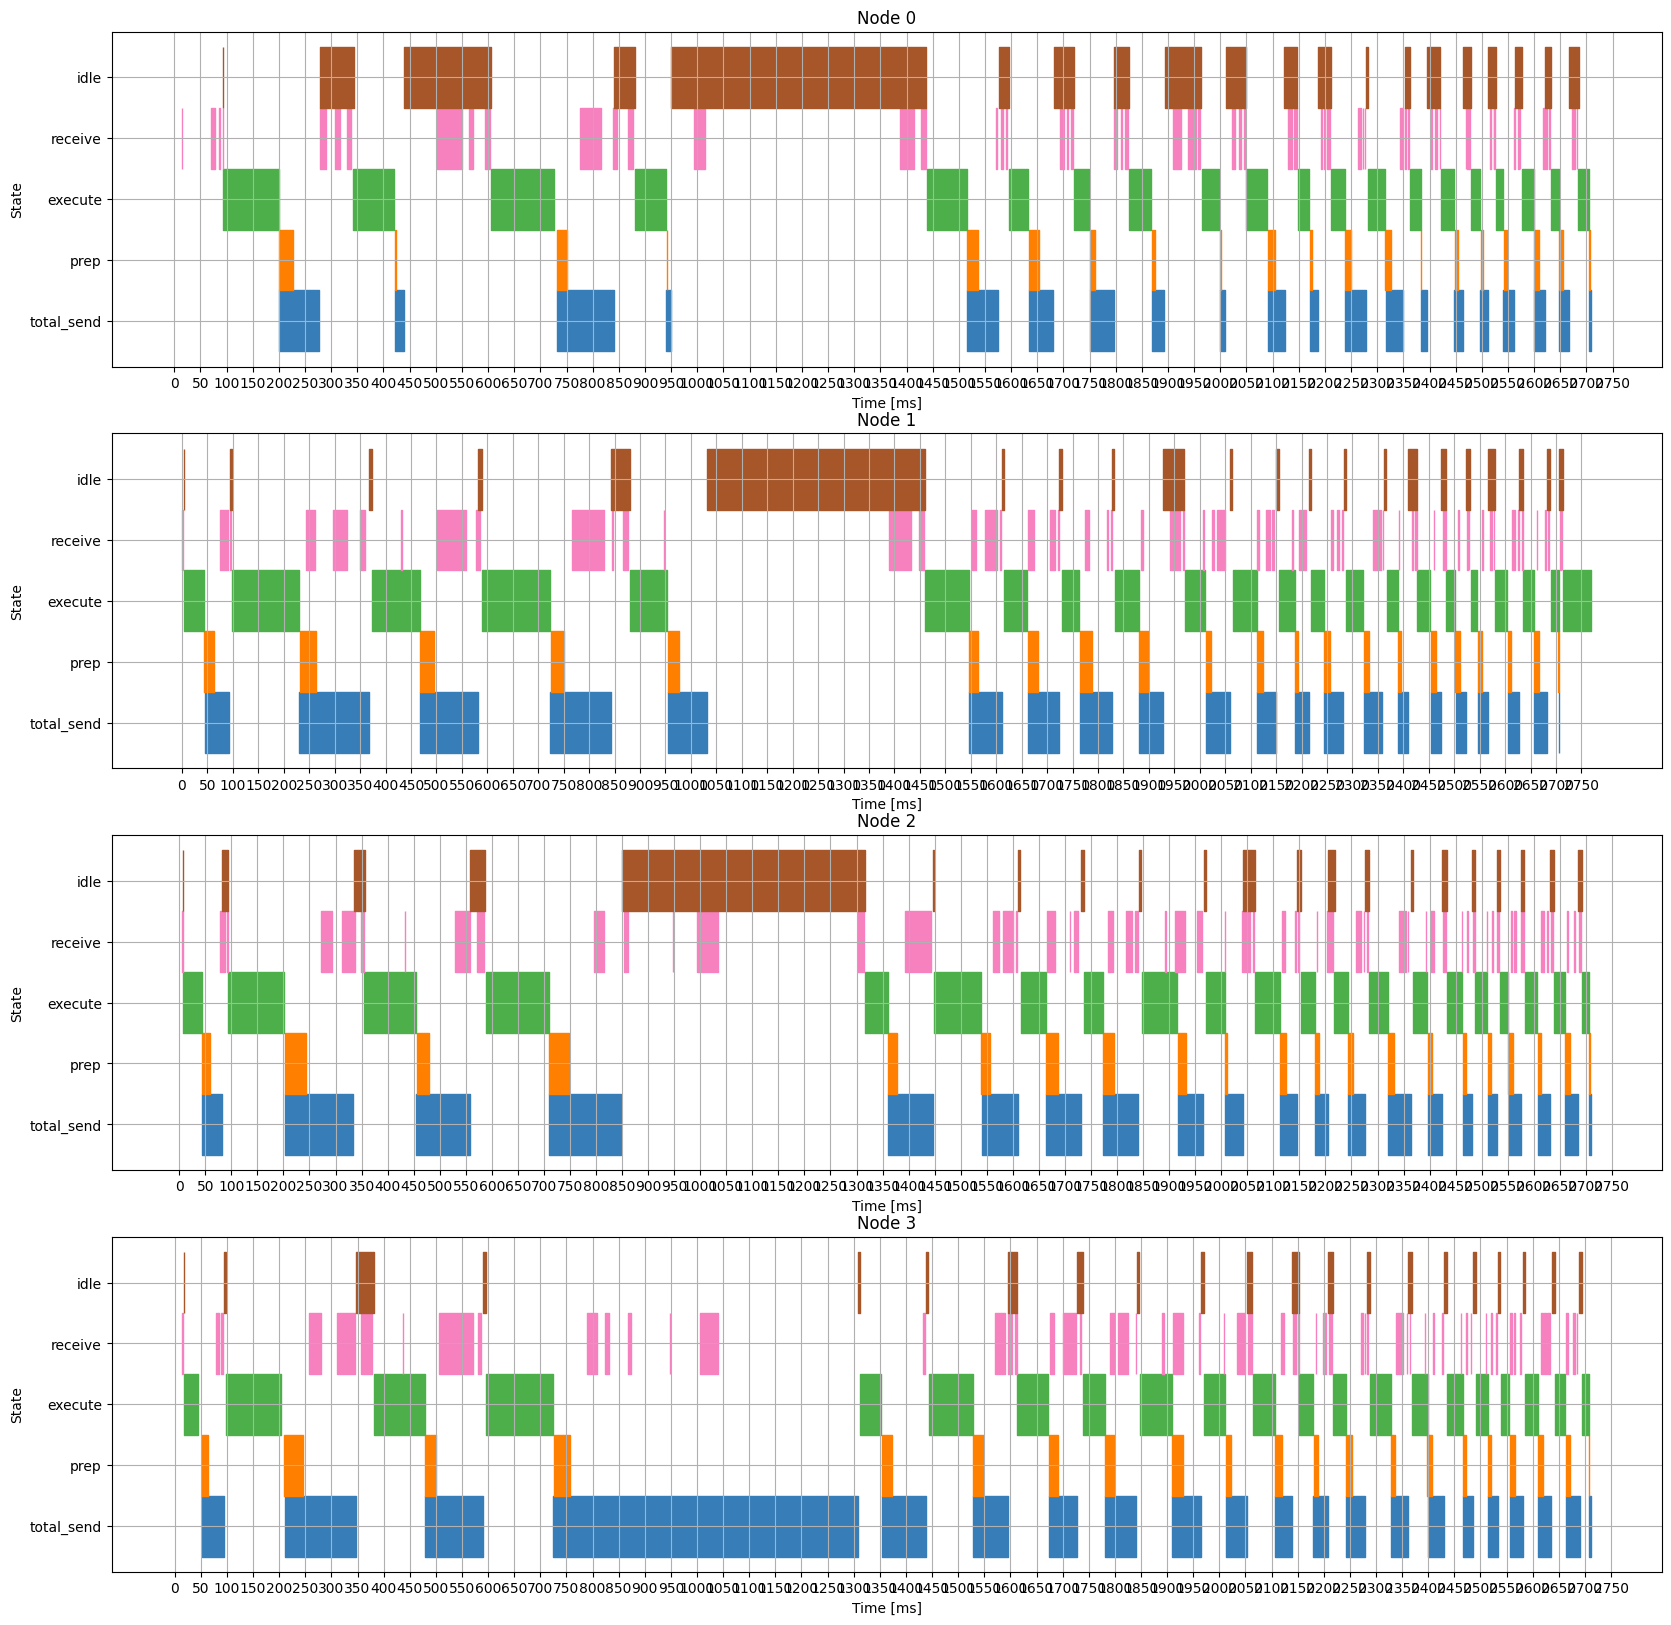

In [5]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=CB_color_cycle[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




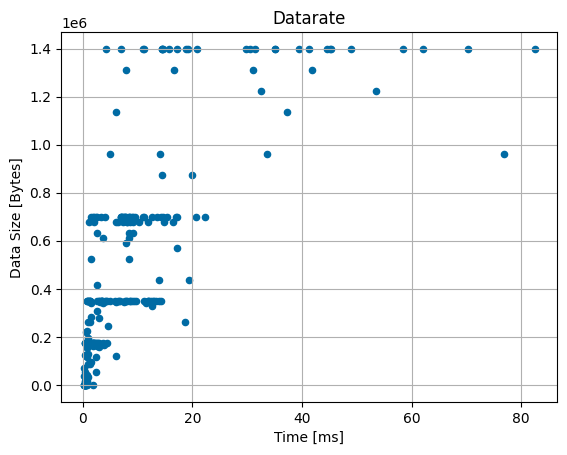

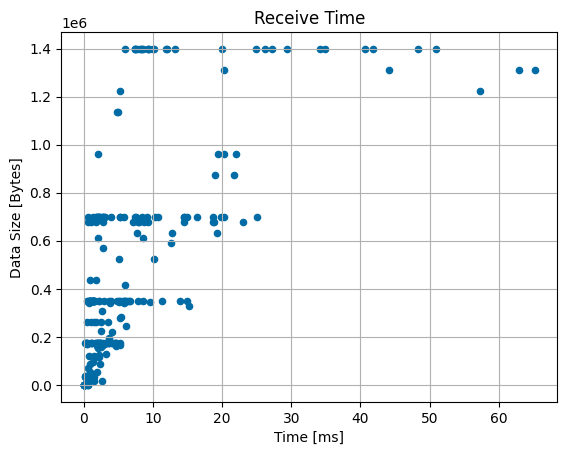

In [6]:
'''
    Make scatter plots for TX and RX
'''

ax_send = block_event_df[block_event_df['type'] == 'send'].plot.scatter(x='dur', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = block_event_df[block_event_df['type'] == 'receive'].plot.scatter(x='dur', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [7]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 2.6156253999797627s
            States    Time [ms]  Percent [%]
0             IDLE  1115.275100    42.638946
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   292.299000     0.026209
3        RX (IDLE)   360.037500    32.282394
4        EXECUTING   836.872500    31.995121
5             PREP   178.808500     6.836166
6            Total     2.615625     0.100000

Node 1
Run time 2.7648863999638706s
            States    Time [ms]  Percent [%]
0             IDLE   629.667700    22.773728
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   610.050300     0.096884
3        RX (IDLE)   463.053500    73.539345
4        EXECUTING  1058.166000    38.271590
5             PREP   307.221300    11.111534
6            Total     2.764886     0.100000

Node 2
Run time 2.702396399981808s
            States   Time [ms]  Percent [%]
0             IDLE  645.515400    23.886777
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)  658.126200     0.10

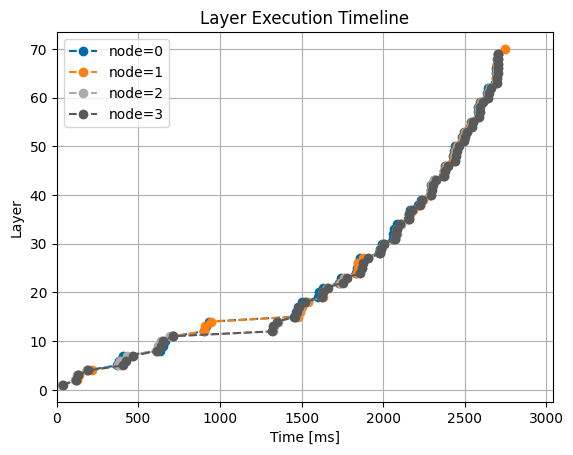

In [8]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(layer_event_df[layer_event_df['node'] == i]['time'] ,layer_event_df[layer_event_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [ms]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1*1e3)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



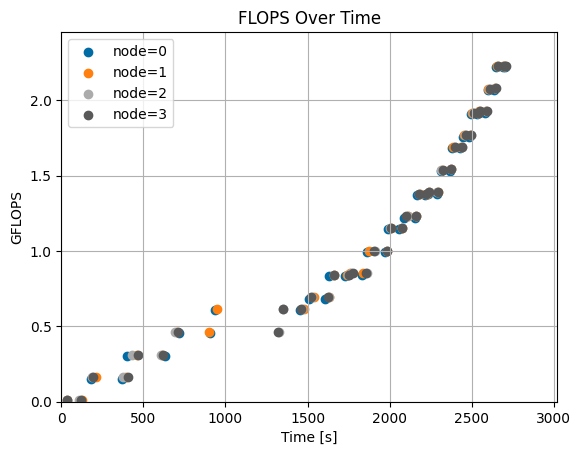

In [9]:

plt.figure()
plt.grid()
legend_strs = []
max_cum_bytes = 0
for i in range(num_nodes):

    tmp_merged_layer_df = layer_event_df[layer_event_df['node'] == i]
    nan_mask = tmp_merged_layer_df['FLOPS'].isna() == 0
    cum_bytes = np.cumsum(tmp_merged_layer_df[nan_mask]['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df[nan_mask]['time'] ,cum_bytes/1e9)

    if max_cum_bytes < cum_bytes[-1]:
        max_cum_bytes = cum_bytes[-1]/1e9

    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(layer_event_df['time'])*1.1)
plt.ylim(0,max_cum_bytes*1.1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


In [10]:
layer_event_df['FLOPS']

3     9437184.0
2     9437184.0
2     9437184.0
1      524288.0
1      524288.0
        ...    
65      40800.0
67          NaN
68          NaN
65      40800.0
0           NaN
Name: FLOPS, Length: 276, dtype: float64

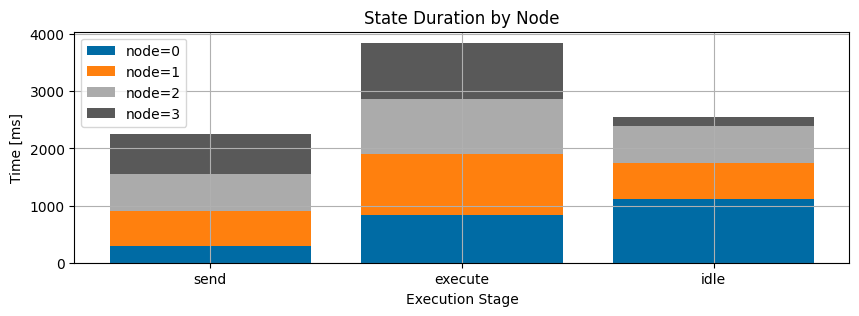

In [11]:
'''
    WIP Compare durations from different states 

'''

stages = ["send", "execute", "idle"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, block_event_df[(block_event_df['node'] == inode) & (block_event_df['type'] == a_stage) ]['dur'].sum(axis=0))
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title(f'State Duration by Node')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, f'state_dur_compare_node-{test_name}.jpg'))

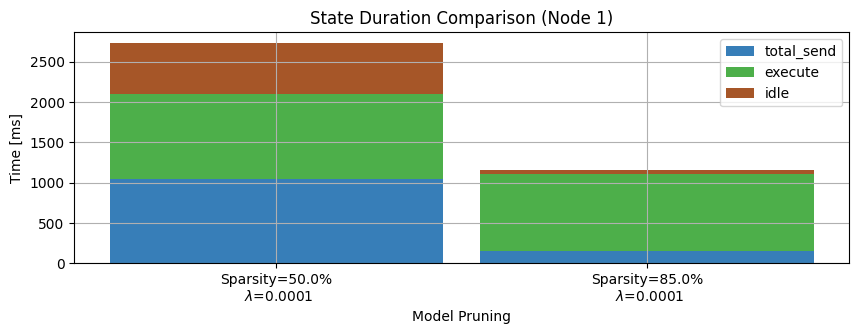

In [13]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
legend_strs = []

width = 0.9

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stages_array = np.append(stages_array, master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0))

    # plot 
    plt.bar(model_names, stages_array, width=width, align='center', bottom=bottom, color=CB_color_cycle_short[istage])

    # increase counters
    bottom += stages_array
    istage += 1
    irun += 1

#ax = plt.gca()
#ax.set_yscale('log')

# labels
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(stages)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare_stacked.jpg'))

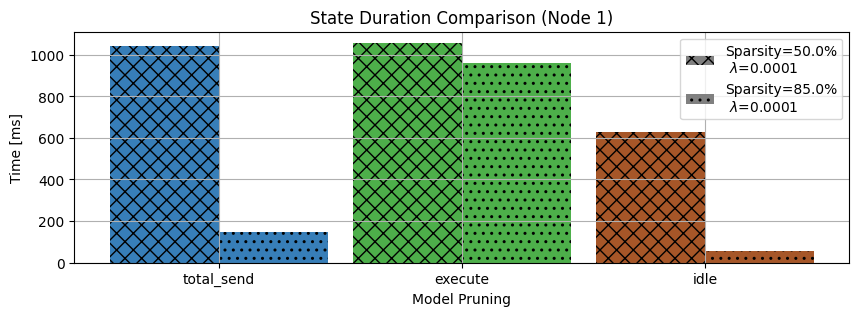

In [14]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''
 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
hatch_list = ["xx", "..", "\\\\", "**"]
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
width = 0.9
stage_values = np.arange(num_stages)*num_runs
run_values = np.arange(num_runs)*width
legend_strs = []

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

    # make dummy bar for legend 
    plt.bar(0, 0, color="gray",  hatch= hatch_list[irun])

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stage_time = master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0)

        # plot 
        plt.bar(stage_values[istage] + run_values[irun] - width/num_runs,
                    stage_time,
                    width=width,
                    align='center', 
                    color=CB_color_cycle_short[istage], 
                    hatch= hatch_list[irun])

    # increase counters
    istage += 1
    irun += 1

# labels
plt.xticks(stage_values, stages)
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(model_names)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare.jpg'))